<a href="https://colab.research.google.com/github/eva-tsvetalina/corpora/blob/master/auv3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pytorch_lightning &> /dev/null

In [2]:
pip install umap-learn &> /dev/null

In [3]:
# Standard libraries
import time
import pandas as pd
import numpy as np
import urllib.request
from pathlib import Path
from urllib.error import HTTPError
from tqdm.notebook import tqdm 
from sklearn import preprocessing
import io


# Pytorch and Pytorch Lightning
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.tuner.tuning import Tuner

from sklearn.model_selection import train_test_split
    
# Path to saved models
CHECKPOINT_PATH = Path("data")
if not CHECKPOINT_PATH.exists():
    CHECKPOINT_PATH.mkdir()

# for reproducibility 
pl.seed_everything(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Use GPU if available, otherwise use cpu instead 
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

INFO:lightning_fabric.utilities.seed:Global seed set to 42


Device: cuda:0


In [4]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
fullds = pd.read_csv("/content/drive/MyDrive/fullds.csv")

In [9]:
bloodchem = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/mouse_BloodChemistry.csv")
bloodchem.head()

,sex,diet,age,HDL,LDL,TotalChol,ALT,ASAT,ALToverASAT,Creatinine,...,LDH,Triglycerides,Bilirubin,FFA,BileAcids,Lactate,Protein,ALPL,Iron,Amylase
0,1,1,367,1.52,0.30,1.6,399.0,884.0,0.45,0.0,...,2913.0,0.61,0.0,0.00,30.2,8.4,40.9,59.112826,20.2,758.0
1,1,2,349,2.03,0.21,1.9,123.0,215.0,0.57,11.0,...,668.0,0.27,0.0,0.62,2.9,9.7,47.2,72.000000,25.7,657.0
2,1,1,186,3.56,0.33,4.5,744.0,1048.0,0.71,13.0,...,1613.0,1.86,0.2,0.58,6.5,9.7,51.2,74.000000,36.3,957.0
3,1,1,188,2.09,0.26,2.3,56.0,229.0,0.24,25.0,...,391.0,0.48,0.0,0.78,219.0,9.0,52.6,84.000000,27.1,964.0
4,1,2,188,2.67,0.24,2.5,262.0,426.0,0.62,19.0,...,944.0,0.49,0.0,0.86,8.7,11.6,55.0,139.000000,25.4,924.0


In [6]:
# FULL DATASET

X = fullds.iloc[:, 3:]  # Features
y = fullds["diet"]     # Target variable

train_ds, val_ds, train_labels, val_labels = train_test_split(X, y, test_size=0.3, random_state=42)
nsamples = fullds.shape[0]
var_features = fullds.shape[1] -3
print("number of samples", nsamples)
print("number of variables", var_features)

number of samples 315
number of variables 24897


In [6]:
# BLOODCHEM

from sklearn.model_selection import train_test_split

X = bloodchem.iloc[:, 3:]  # Features
y = bloodchem["diet"]     # Target variable

train_ds, val_ds, train_labels, val_labels = train_test_split(X, y, test_size=0.3, random_state=42)
nsamples = bloodchem.shape[0]
var_features = bloodchem.shape[1] -3
print("number of samples", nsamples)
print("number of variables", var_features)

number of samples 315
number of variables 19


In [7]:
le = preprocessing.LabelEncoder()
train_labels_encoded = le.fit_transform(train_labels)
val_labels_encoded = le.transform(val_labels)

In [8]:
# create Custome dataset for tabular data
class TabularDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [9]:
# batch size
#bs = 10
bs = 32

train_dataset = TabularDataset(torch.tensor(train_ds.values).float(), torch.tensor(train_labels_encoded).long())
val_dataset = TabularDataset(torch.tensor(val_ds.values).float(), torch.tensor(val_labels_encoded).long())

train_dl = DataLoader(train_dataset, batch_size=bs, shuffle=True, drop_last=True, pin_memory=True)
val_dl = DataLoader(val_dataset, batch_size=bs, shuffle=False, drop_last=False)

In [10]:
x, y = train_dl.dataset[0]
print("Input data:", x)
print("Label:     ", y)

Input data: tensor([1.5400, 0.1900, 1.7000,  ..., 1.1420, 1.7400, 0.2790])
Label:      tensor(1)


In [11]:
class LinBnDrop(nn.Sequential):
    """Module grouping `BatchNorm1d`, `Dropout` and `Linear` layers, adapted from fastai."""
    
    def __init__(self, n_in, n_out, bn=True, p=0., act=None, lin_first=True):
        layers = [nn.BatchNorm1d(n_out if lin_first else n_in)] if bn else []
        if p != 0: layers.append(nn.Dropout(p))
        lin = [nn.Linear(n_in, n_out, bias=not bn)]
        if act is not None: lin.append(act)
        layers = lin+layers if lin_first else layers+lin
        super().__init__(*layers)

In [12]:
class Encoder(nn.Module):
    """Encoder for CITE-seq data"""
    def __init__(self,
                 var_features: int,
                 hidden_features: int,
                 latent_dim: int,
                 p: float = 0):
        super().__init__()
        self.var_features = var_features
        hidden_dim = var_features
        
        self.encoder_protein = LinBnDrop(var_features, hidden_features, p=p, act=nn.LeakyReLU())
        self.encoder = LinBnDrop(hidden_dim, latent_dim, act=nn.LeakyReLU())

    def forward(self, x):
        return self.encoder(x)

The given code defines an encoder neural network module in PyTorch. The encoder takes an input tensor x and produces a compressed representation of it as output.

The encoder module has three layers:

encoder_protein: This layer is defined as an instance of the LinBnDrop class, which performs a linear transformation on the input tensor followed by batch normalization and dropout. The input size to this layer is var_features, and the output size is hidden_features. The activation function used in this layer is the Leaky ReLU activation function.

encoder: This layer is defined as another instance of the LinBnDrop class. The input size to this layer is the same as the output size of the previous layer (hidden_features). The output size of this layer is latent_dim, which is the size of the compressed representation of the input tensor. The activation function used in this layer is also the Leaky ReLU activation function.

forward: This method defines the forward pass of the encoder module. It takes an input tensor x, passes it through the encoder_protein layer, applies the Leaky ReLU activation function, and then passes the result through the encoder layer to produce the final compressed representation of the input tensor.

Therefore, the flow of information in the given code is as follows: The input tensor x is first passed through the encoder_protein layer, which performs a linear transformation on it, followed by batch normalization and dropout. The resulting tensor is then passed through the Leaky ReLU activation function and fed as input to the encoder layer. The encoder layer again performs a linear transformation followed by batch normalization and dropout and produces the final compressed representation of the input tensor. The compressed representation is returned as output from the forward method.

In [13]:
class Decoder(nn.Module):
    """Decoder for CITE-seq data"""
    def __init__(self,
                 var_features: int,
                 hidden_features: int,
                 latent_dim: int):
        super().__init__()
        hidden_dim = hidden_features
        out_dim = var_features
        
        self.decoder = nn.Sequential(
            LinBnDrop(latent_dim, hidden_dim, act=nn.LeakyReLU()),
            LinBnDrop(hidden_dim, out_dim // 2, act=nn.LeakyReLU()),
            LinBnDrop(out_dim // 2, out_dim, bn=False)
            )

    def forward(self, x):
        return self.decoder(x)

The given code defines a decoder neural network module in PyTorch. The decoder takes a compressed representation of the input tensor as input and produces a reconstructed tensor as output.

The decoder module has three layers:

decoder: This layer is defined as an instance of the nn.Sequential class, which is used to combine multiple layers into a single module. The decoder layer consists of three instances of the LinBnDrop class, which perform linear transformations on the input tensor followed by batch normalization and dropout. The input size to the first layer is latent_dim, which is the size of the compressed representation of the input tensor. The output size of the first layer is hidden_dim, which is set to be equal to hidden_features. The activation function used in this layer is the Leaky ReLU activation function.

The output size of the second layer is out_dim // 2, where out_dim is the size of the input tensor. The activation function used in this layer is also the Leaky ReLU activation function.

The output size of the third and final layer is out_dim, which is the same as the size of the input tensor. This layer does not perform batch normalization.

forward: This method defines the forward pass of the decoder module. It takes an input tensor x, which is the compressed representation of the input tensor. The input tensor is passed through the decoder layer to produce the reconstructed tensor, which is returned as output.

Therefore, the flow of information in the given code is as follows: The compressed representation of the input tensor x is first passed through the decoder layer, which performs a linear transformation on it followed by batch normalization and dropout. The resulting tensor is then passed through the Leaky ReLU activation function and fed as input to the next layer, which again performs a linear transformation followed by batch normalization and dropout. The output of the second layer is then passed through the Leaky ReLU activation function and fed as input to the final layer, which performs a linear transformation and produces the reconstructed tensor. The reconstructed tensor is returned as output from the forward method.

In [14]:
class CiteAutoencoder(pl.LightningModule):
    def __init__(self,
                 var_features: int,
                 hidden_features: int,
                 latent_dim: int,
                 p: float = 0,
                 lr: float = 0.1):
        """ Autoencoder for citeseq data """
        super().__init__()
        
        # save hyperparameters
        self.save_hyperparameters()
 
        self.encoder = Encoder(var_features, hidden_features, latent_dim, p)
        self.decoder = Decoder(var_features, hidden_features, latent_dim)
        
        # example input array for visualizing network graph
        self.example_input_array = torch.zeros(256, var_features)

    def forward(self, x):
        # extract latent embeddings
        z = self.encoder(x)
        return z
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.hparams.lr)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}
    
    def _get_reconstruction_loss(self, batch):
        """ Calculate MSE loss for a given batch. """
        x, _ = batch
        z = self.encoder(x)
        x_hat = self.decoder(z)
        # MSE loss
        loss = F.mse_loss(x_hat, x)
        return loss
    
    def training_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log("train_loss", loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log("val_loss", loss)

    def fit(self, train_dataloader, val_dataloader, max_epochs=100):
        trainer = pl.Trainer(max_epochs=max_epochs)
        trainer.fit(self, train_dataloader=train_dataloader, val_dataloaders=val_dataloader)

    def callback_metrics(self):
        return {"train_loss": self.training_loss.compute(), "val_loss": self.validation_loss.compute()}

    def extract_latent_embeddings(self, dataloader):
        """ Extract latent embeddings from autoencoder """
        self.eval()
        embeddings = []
        with torch.no_grad():
            for batch in dataloader:
                x, y = batch
                z = self.encoder(x)
                embeddings.append(z)
        return torch.cat(embeddings, dim=0)

the size of the bottleneck = latent_dim

In [15]:
# IT IS TRAINING

def train_citeseq(hidden_features: int = 30, latent_dim: int = 35, p: float = 0.1, lr: float = 0.1):
    trainer = pl.Trainer(default_root_dir=CHECKPOINT_PATH,
                         gpus=1 if "cuda" in str(device) else 0,
                         max_epochs=150,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="min", monitor="val_loss"),
                                    LearningRateMonitor("epoch")])
    trainer.logger._log_graph = True
    trainer.logger._default_hp_metric = None
    
    model = CiteAutoencoder(var_features, hidden_features=hidden_features, latent_dim=latent_dim, p=p, lr=lr)
    trainer.fit(model, train_dl, val_dl)
    
    train_loss = trainer.callback_metrics['train_loss'].item()
    val_loss = trainer.callback_metrics['val_loss'].item()
    result = {"train_loss": train_loss, "val_loss": val_loss}
    return model, result, trainer


In [ ]:
# TO BE TESTED IF IT WORKS
# two differenced: early stopping, loss is too big so it stopss at 42 epoch; Returns the trainer as well

from pytorch_lightning.callbacks.early_stopping import EarlyStopping


def train_citeseq(hidden_features: int = 30, latent_dim: int = 10, p: float = 0.1, lr: float = 0.1):
    trainer = pl.Trainer(default_root_dir=CHECKPOINT_PATH,
                         gpus=1 if "cuda" in str(device) else 0,
                         max_epochs=150,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="min", monitor="val_loss"),
                                    LearningRateMonitor("epoch")])
                                    # EarlyStopping(monitor="val_loss", patience=10
    trainer.logger._log_graph = True
    trainer.logger._default_hp_metric = None
    
    model = CiteAutoencoder(var_features, hidden_features=hidden_features, latent_dim=latent_dim, p=p, lr=lr)
    trainer.fit(model, train_dl, val_dl)
    
    train_loss = trainer.callback_metrics['train_loss'].item()
    val_loss = trainer.callback_metrics['val_loss'].item()
    result = {"train_loss": train_loss, "val_loss": val_loss}
    return model, result, trainer


In [16]:
model, result, trainer = train_citeseq()

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type    | Params | In sizes     | Out sizes
---------------------------------------------------------------
0 | encoder | Encoder | 1.6 M  | [256, 24897] | [256, 35]
1 | decoder | Decoder | 310 M  | ?            | ?        
----------

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=150` reached.


In [17]:
def print_results(result):
    print("Training loss: {:.4f}".format(result['train_loss']))
    print("Validation loss: {:.4f}".format(result['val_loss']))

print_results(result)

Training loss: 89.0908
Validation loss: 82.6675


# model visualisation

In [22]:
!pip install torchsummaryX  &> /dev/null

In [23]:
from torchsummaryX import summary

input_tensor = torch.zeros(bs, var_features)
print(summary(model, input_tensor))


                                Kernel Shape Output Shape    Params Mult-Adds
Layer                                                                        
0_encoder.encoder.Linear_0       [24897, 35]     [32, 35]  871.395k  871.395k
1_encoder.encoder.LeakyReLU_1              -     [32, 35]         -         -
2_encoder.encoder.BatchNorm1d_2         [35]     [32, 35]      70.0      35.0
------------------------------------------------------------------------------
                        Totals
Total params          871.465k
Trainable params      871.465k
Non-trainable params       0.0
Mult-Adds              871.43k
                                Kernel Shape Output Shape    Params  Mult-Adds
Layer                                                                         
0_encoder.encoder.Linear_0       [24897, 35]     [32, 35]  871395.0   871395.0
1_encoder.encoder.LeakyReLU_1              -     [32, 35]       NaN        NaN
2_encoder.encoder.BatchNorm1d_2         [35]     [32, 35]   

/usr/local/lib/python3.8/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_sum = df.sum()


In [24]:
pip install torchviz &> /dev/null

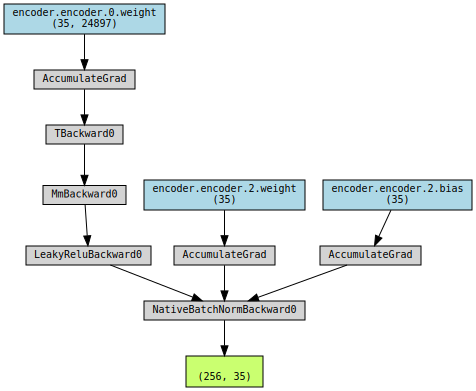

In [25]:
from torchviz import make_dot

# create an instance of the autoencoder model

# create an example input tensor
x = torch.zeros(256, var_features)

# pass the input tensor through the model and generate a graph
y = model(x)
make_dot(y, params=dict(model.named_parameters()))


In [26]:
import matplotlib.pyplot as plt

def plot_loss(trainer):
    train_loss = trainer.callback_metrics['train_loss'].detach().cpu().numpy()
    val_loss = trainer.callback_metrics['val_loss'].detach().cpu().numpy()
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(train_loss, label='Train Loss')
    ax.plot(val_loss, label='Val Loss')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()
    plt.show()


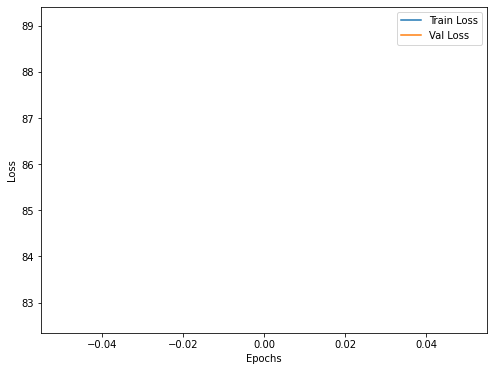

In [27]:
plot_loss(trainer)

# AU to RF

In [28]:
# # Load trained autoencoder from checkpoint
# autoencoder = CiteAutoencoder.load_from_checkpoint("/content/drive/MyDrive/checkpoints/lightning_logs/version_0/checkpoints/epoch=52-step=1166.ckpt")

# # Obtain latent embeddings for training dataset
# train_embeddings = autoencoder.extract_latent_embeddings(train_dl)

# # Obtain latent embeddings for validation dataset
# val_embeddings = autoencoder.extract_latent_embeddings(val_dl)


In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

def train_random_forest(train_dl, val_dl):
    # Load the trained encoder
    # have  to load the file every time manually
    encoder = CiteAutoencoder.load_from_checkpoint("/content/data/lightning_logs/version_0/checkpoints/epoch=132-step=798.ckpt").encoder
    #encoder = CiteAutoencoder.load_from_checkpoint(CHECKPOINT_PATH).encoder

    
    # Generate embeddings for the training and validation data
    train_embeddings = []
    train_labels = []
    for batch in train_dl:
        x, y = batch
        embeddings = encoder(x)
        train_embeddings.append(embeddings.detach().numpy())
        train_labels.append(y.detach().numpy())
    train_embeddings = np.concatenate(train_embeddings, axis=0)
    train_labels = np.concatenate(train_labels, axis=0)
    
    val_embeddings = []
    val_labels = []
    for batch in val_dl:
        x, y = batch
        embeddings = encoder(x)
        val_embeddings.append(embeddings.detach().numpy())
        val_labels.append(y.detach().numpy())
    val_embeddings = np.concatenate(val_embeddings, axis=0)
    val_labels = np.concatenate(val_labels, axis=0)
    #print(val_embeddings)
    #embedings is a continiouse var. confussion matrix only accepts binary lables

    # Train a random forest classifier on the embeddings
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(train_embeddings, train_labels)
    # train_embeddings = x_train
    # train_labels = y_train
    # val_preds = y_pred
    # val_embeddings = x_test
    # val_labels = y_test


    # Evaluate on the validation set
    val_preds = rf.predict(val_embeddings) # y_pred
    val_acc = (val_preds == val_labels).mean()
    print(classification_report(val_labels, val_preds))
    print(f"Validation accuracy: {val_acc:.4f}")

    cm = confusion_matrix(val_labels, val_preds)
    cm_display = ConfusionMatrixDisplay(cm).plot()

    return rf, cm_display


              precision    recall  f1-score   support

           0       0.71      0.60      0.65        45
           1       0.68      0.78      0.73        50

    accuracy                           0.69        95
   macro avg       0.70      0.69      0.69        95
weighted avg       0.70      0.69      0.69        95

Validation accuracy: 0.6947


(RandomForestClassifier(random_state=42),
 <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x7f1f1b0df070>)

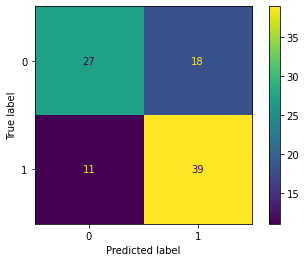

In [40]:
train_random_forest(train_dl, val_dl)

# PCA to RF

In [33]:
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

def pca_rf_classifier(X_train, y_train, X_test, y_test, n_components=10, n_estimators=100, random_state=42):
    # Perform PCA
    pca = PCA(n_components=n_components)
    pca.fit(X_train)
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)

    # Build random forest classifier
    rf = RandomForestClassifier(n_estimators=n_estimators)
    rf.fit(X_train_pca, y_train)

    # Predict test set labels
    y_pred = rf.predict(X_test_pca)
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    cm_display = ConfusionMatrixDisplay(cm).plot()
    return cm_display


              precision    recall  f1-score   support

           1       0.78      0.87      0.82        45
           2       0.87      0.78      0.82        50

    accuracy                           0.82        95
   macro avg       0.82      0.82      0.82        95
weighted avg       0.83      0.82      0.82        95



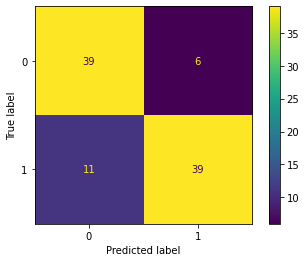

In [34]:
pca_rf_classifier(train_ds, train_labels, val_ds, val_labels, n_components=10, n_estimators=100)

# PCA va AU feature extraction comparison

A common way to compare the performance of autoencoders and PCA is to plot the reconstructed data points against the original data points in a scatter plot. The x-axis would represent the original data points while the y-axis would represent the reconstructed data points. The closer the points are to a diagonal line, the better the performance of the method. Additionally, the scatter plot can be colored by a categorical variable to see if the method captures differences between groups in the data.

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA


"""
this function assumes that the input data is a numpy array or PyTorch tensor of shape (num_samples, num_features). 
It also assumes that autoencoder is a trained instance of the CiteAutoencoder class defined earlier, and that pca is a trained instance of scikit-learn's PCA class. 
The function first encodes the data using the autoencoder's encoder, and then uses PCA to reduce the data to the same number of dimensions as the autoencoder's latent space. 
It then plots the encoded data and the PCA-transformed data side by side for comparison.
"""



# def compare_autoencoder_pca(data, autoencoder, pca):
#     # Convert X to a PyTorch tensor
#     data = torch.tensor(X.values).float()

#     # Use the trained autoencoder to encode the data
#     encoded_data = autoencoder.encoder(data)
    
#     # Use PCA to reduce the data to the same number of dimensions as the autoencoder's latent space
#     pca = PCA(n_components=autoencoder.hparams.latent_dim)
#     pca.fit(data)
#     pca_data = pca.transform(data)
    
#     # Plot the encoded data against the PCA-transformed data
#     fig, ax = plt.subplots(1, 2, figsize=(12, 6))
#     sns.scatterplot(x=encoded_data[:, 0], y=encoded_data[:, 1], ax=ax[0])
#     ax[0].set_title("Autoencoder")
#     sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], ax=ax[1])
#     ax[1].set_title("PCA")
#     plt.show()

def compare_autoencoder_pca(data, autoencoder, pca):
  # Convert X to a PyTorch tensor
  data = torch.tensor(X.values).float()
    
  # Use the trained autoencoder to encode the data
  encoded_data = autoencoder.encoder(data)
    
  # Use PCA to reduce the data to the same number of dimensions as the autoencoder's latent space
  pca = PCA(n_components=autoencoder.hparams.latent_dim)
  # scale = True by default
  pca.fit(X)
  pca_data = pca.transform(X)
    
  # Plot the encoded data against the PCA-transformed data
  fig, ax = plt.subplots(1, 2, figsize=(12, 6))
  sns.scatterplot(x=encoded_data[:, 0].detach().numpy(), y=encoded_data[:, 1].detach().numpy(), ax=ax[0])
  ax[0].set_title("Autoencoder")
  ax[0].set_xlabel("First latent dimention")
  ax[0].set_ylabel("Second latent dimention")
  sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], ax=ax[1])
  ax[1].set_title("PCA")
  ax[1].set_xlabel("First principle component")
  ax[1].set_ylabel("Second principle component")

  plt.show()


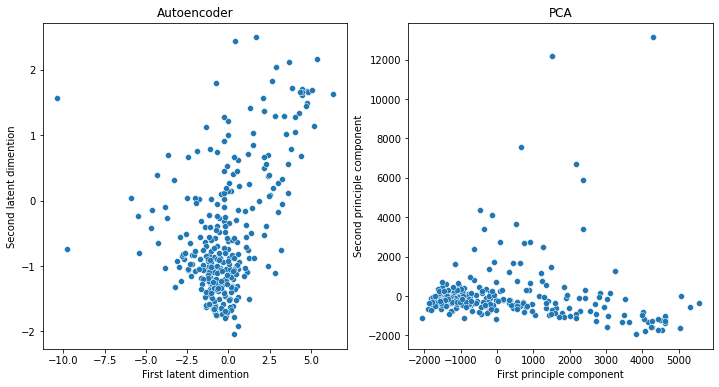

In [22]:
compare_autoencoder_pca(X, model, PCA())
# add variation explained for both the au and rf

VARIATION EXPLAINED IN AN AUTOENCODER

There is an equivalent to the PCA variation explained in an autoencoder. In PCA, the variation explained by each principal component can be calculated as the ratio of the eigenvalue associated with that principal component to the sum of all eigenvalues. This gives a measure of how much of the variation in the data is captured by each principal component.

Similarly, in an autoencoder, the variation explained by each latent dimension can be calculated as the ratio of the variance of the encoded data along that dimension to the total variance of the encoded data. This gives a measure of how much of the variation in the data is captured by each latent dimension.

The sum of the variations explained by all the latent dimensions should be equal to 1, just like in PCA, indicating that all the variation in the data has been captured by the autoencoder.

#Hyperparameter tuning

In [ ]:
def tune_hyperparameters():
    # define hyperparameters to tune
    hidden_features_list = [20, 30, 40]
    latent_dim_list = [30, 35, 40]
    p_list = [0.1, 0.2, 0.3]
    lr_list = [0.01, 0.01, 0.1]

    # keep track of the best hyperparameters and corresponding validation loss
    best_loss = float("inf")
    best_hyperparameters = {}

    # perform grid search
    for hidden_features in hidden_features_list:
        for latent_dim in latent_dim_list:
            for p in p_list:
                for lr in lr_list:
                    print(f"Training with hyperparameters: hidden_features={hidden_features}, latent_dim={latent_dim}, p={p}, lr={lr}")

                    # train model with current hyperparameters
                    model = CiteAutoencoder(var_features, hidden_features, latent_dim, p, lr)
                    trainer = pl.Trainer(gpus=1 if "cuda" in str(device) else 0)
                    trainer.fit(model, train_dl, val_dl)

                    # evaluate model on validation set
                    result = trainer.test(model, val_dl)
                    val_loss = result[0]["test_loss"]

                    # check if current hyperparameters are the best so far
                    if val_loss < best_loss:
                        best_loss = val_loss
                        best_hyperparameters = {"hidden_features": hidden_features, "latent_dim": latent_dim, "p": p, "lr": lr}

    print(f"Best hyperparameters: {best_hyperparameters}")
    print(f"Corresponding validation loss: {best_loss}")


In [ ]:
tune_hyperparameters()

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import pytorch_lightning as pl

def tune_hyperparameters():
    # define hyperparameters to tune
    # define hyperparameters to tune
    hidden_features_list = [20, 30, 40]
    latent_dim_list = [30, 35, 40]
    p_list = [0.1, 0.2, 0.3]
    lr_list = [0.01, 0.01, 0.1]

    # define training configuration
    training_config = {
        "max_epochs": 10,
        "gpus": 1,
    }
    
    # define trainer
    trainer = pl.Trainer(**training_config)
    
    
    # perform hyperparameter tuning
    reporter = CLIReporter(metric_columns=["loss", "accuracy"])
    result = tune.run(
        partial(train_model, model=model, trainer=trainer, val_dataloaders=val_dl),
        resources_per_trial={"gpu": 1},
        config=hyperparameters,
        verbose=1,
        progress_reporter=reporter,
    )
    
    print(result.best_trial)


In [ ]:
pip install "ray[tune]" &> /dev/null

In [ ]:
pip install "pytorch-lightning>=1.0" &> /dev/null

In [ ]:
pip install "pytorch-lightning-bolts>=0.2.5" &> /dev/null

In [ ]:
config = {
    "learning_rate": 0.01,
    "num_epochs": 10,
    "batch_size": 32,
    "hidden_size": 64,
    "dropout": 0.5,
    "weight_decay": 0.0001
}


In [ ]:
config = {
    "lr": [0.01, 0.1],
    "batch_size": [10, 30, 50],
    "model": {
        "hidden_size": [64, 128],
        "num_layers": [1, 2, 3]
    }
}


In [ ]:
from pytorch_lightning.callbacks.progress import TQDMProgressBar


In [ ]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
#from pytorch_lightning.callbacks.progress import ProgressBar
from pytorch_lightning.callbacks import LearningRateMonitor
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

def tune_hyperparameters(config):
    # train and validation data loaders
    train_dl = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True, num_workers=4)
    val_dl = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=False, num_workers=4)

    # define the LightningModule
    model = CiteAutoencoder(config["learning_rate"], config["dropout"])

    # define the trainer
    logger = TensorBoardLogger("tb_logs", name="tune_exp")
    early_stop_callback = EarlyStopping(monitor="val_loss", patience=5, mode="min")
    lr_monitor = LearningRateMonitor(logging_interval="epoch")
    #progress_bar = ProgressBar()
    progress_bar = TQDMProgressBar()
    trainer = Trainer(
        gpus=1,
        logger=logger,
        callbacks=[early_stop_callback, lr_monitor, progress_bar],
        max_epochs=config["epochs"],
        progress_bar_refresh_rate=30,
        auto_scale_batch_size=True,
        auto_lr_find=True
    )

    # train the model
    trainer.fit(model, train_dataloader=train_dl, val_dataloaders=val_dl)

    # evaluate model on validation set
    result = trainer.validate(val_dataloaders=val_dl)
    val_loss = result[0]["val_loss"]

    # return the validation loss
    return {"val_loss": val_loss}


In [ ]:
tune_hyperparameters(config)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


TypeError: ignored